Script to generate Fig 6 (excluding script to generate swmt calculations, see Fig 2 for details of that process):
- (a) Timeseries of monthly mean mixed layer depths (MLD) spatially averaged over the four continental
shelf regions that generate DSW under the control forcing. MLD is diagnosed online in ACCESS-OM2-01 as the
depth at which potential density (referenced to 0 db, s0) exceeds the surface density by 0.03 kg m?3. (b) Map of
regions over which spatial averages are computed in (a). (c) Surface water-mass transformation rates integrated
over the Antarctic continental shelf region (poleward of 1000 m isobath) and averaged over the 5th (dashed)
and 10th (solid) years of the experimental period for the control (black), MW45 (blue), and MW85 (orange)
simulations. Transformation rates, which are calculated using monthly mean model output, do not drift over the
control simulation, so only values for the 10th year of this run are shown. Note the convergence of the surface
water-mass transformation rate is interpreted as the time-mean water-mass formation rate in a given density class,
with positive formation indicating upwelling and negative formation indicating downwelling. Thus maximum
positive transport values in (c) approximate the rate of surface transformation into downwelling density classes.
Values below this maximum (higher density) provide a density range for downwelling waters, whilst values
above this maximum (lower density) provide a density range for upwelling waters.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from gsw import SA_from_SP, p_from_z, CT_from_pt, beta, sigma1
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from dask.distributed import Client
client = Client('tcp://localhost:8786')
import cmocean.cm as cmo
from matplotlib import rc
import warnings
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 
import matplotlib.cm as cm
cmap = cm.get_cmap('Oranges')
orange_color = cmap(0.75)
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [5]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [2]:
def get_SWMT(dirpath, time_bounds):
    net_transformation = xr.open_dataset(dirpath+'SWMT_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(dirpath+'HT_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(dirpath+'ST_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation
    
    return  net_transformation, heat_transformation, salt_transformation

In [3]:
####### loading and computations for swmt ########
swmt_control = '/g/data/v45/rm2389/SWMT/01deg_jra55v13_ryf8485_spinup6/'
swmt_rcp45 = '/g/data/v45/rm2389/SWMT/01deg_jra55v13_ryf8485_freshRCP45/'
swmt_rcp85 = '/g/data/v45/rm2389/SWMT/01deg_jra55v13_ryf8485_freshRCP85/'
time_bounds_5 = '1941_6-1942_5'
time_bounds_10 = '1946_6-1947_5'
## re-load the swmt computations
net_transformation_control_5 = get_SWMT(swmt_control, time_bounds_5)[0]
net_transformation_rcp45_5 = get_SWMT(swmt_rcp45, time_bounds_5)[0]
net_transformation_rcp85_5 = get_SWMT(swmt_rcp85, time_bounds_5)[0]
net_transformation_rcp45_10 = get_SWMT(swmt_rcp45, time_bounds_10)[0]
net_transformation_rcp85_10 = get_SWMT(swmt_rcp85, time_bounds_10)[0]

In [6]:
# mask for the continental shelf region
net_transformation_control_5, shelf_mask = shelf_mask_isobath(net_transformation_control_5)
net_transformation_rcp45_5, shelf_mask = shelf_mask_isobath(net_transformation_rcp45_5)
net_transformation_rcp85_5, shelf_mask = shelf_mask_isobath(net_transformation_rcp85_5)
net_transformation_rcp45_10, shelf_mask = shelf_mask_isobath(net_transformation_rcp45_10)
net_transformation_rcp85_10, shelf_mask = shelf_mask_isobath(net_transformation_rcp85_10)

## get mapping information
area_t = cc.querying.getvar(control, 'area_t', session, ncfile ='ocean_grid.nc',n = 1)
area_t = area_t.sel(yt_ocean = slice(-90, -59))
yt_ocean =area_t.yt_ocean.values
xt_ocean =area_t.xt_ocean.values
isopycnal_bin_mid = net_transformation_control_5.isopycnal_bins.values

net_sum_control_5 = (net_transformation_control_5 * area_t/1.e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values * -1
net_sum_rcp45_5 = (net_transformation_rcp45_5 * area_t/1.e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values * -1
net_sum_rcp85_5 = (net_transformation_rcp85_5 * area_t/1.e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values * -1
net_sum_rcp45_10 = (net_transformation_rcp45_10 * area_t/1.e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values * -1
net_sum_rcp85_10 = (net_transformation_rcp85_10 * area_t/1.e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values * -1

In [26]:
def shelf_SWMT_plot(ax):   
    ax.plot(net_sum_control_5,isopycnal_bin_mid,color = 'k', linewidth = 2, label = 'Control')
    ax.plot(net_sum_rcp45_5,isopycnal_bin_mid,color = 'mediumblue', linewidth = 2, linestyle  = ':',label = 'MW45 (Year 5)')
    ax.plot(net_sum_rcp45_10,isopycnal_bin_mid,color = 'mediumblue', linewidth = 2, label = 'MW45 (Year 10)')
    ax.plot(net_sum_rcp85_5,isopycnal_bin_mid,color = orange_color, linewidth = 2,linestyle  = ':',label = 'MW85 (Year 5)')
    ax.plot(net_sum_rcp85_10,isopycnal_bin_mid,color = orange_color, linewidth = 2, label = 'MW85 (Year 10)')
    ax.plot([0,0],[31,33.2],'k',linewidth=0.5)
    ax.set_ylim((33.2,31))
    ax.set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 24)
    ax.set_xlabel('Surface water-mass transformation (Sv)', fontsize = 24)
    ax.legend(loc=1, fontsize = 20)

In [8]:
mld_control = cc.querying.getvar(control, 'mld', session,n=-66, ncfile = 'ocean_month.nc')
mld_rcp85 = cc.querying.getvar(rcp85, 'mld', session,n=None, ncfile = 'ocean_month.nc')
mld_rcp45 = cc.querying.getvar(rcp45, 'mld', session,n=None, ncfile = 'ocean_month.nc')

In [9]:
mld_control, shelf_mask = shelf_mask_isobath(mld_control.sel(time = slice('1937-06','1947-05')))
mld_rcp85, shelf_mask = shelf_mask_isobath(mld_rcp85.sel(time = slice('1937-06','1947-05')))
mld_rcp45, shelf_mask = shelf_mask_isobath(mld_rcp45.sel(time = slice('1937-06','1947-05')))

In [10]:
blank = shelf_mask * 0 + 1
ross_mask = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -59).where(blank.xt_ocean > -198).where(blank.xt_ocean < -157)
ross_map = ross_mask.fillna(0)
adelie_mask = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -59).where(blank.xt_ocean > -234).where(blank.xt_ocean < -198)
adelie_map = adelie_mask.fillna(0)
prydz_mask_1 = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -59).where(blank.xt_ocean > -280).where(blank.xt_ocean < -264)
prydz_mask_2 = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -59).where(blank.xt_ocean > 48).where(blank.xt_ocean < 80)
prydz_map_2 = prydz_mask_2.fillna(0)
prydz_map_1 = prydz_mask_1.fillna(0)
prydz_map = prydz_map_1+prydz_map_2
prydz_mask = prydz_map.where(prydz_map>0)
weddell_mask = blank.where(blank.yt_ocean > -80).where(blank.yt_ocean < -59).where(blank.xt_ocean > -62).where(blank.xt_ocean < -25)
weddell_map = weddell_mask.fillna(0)

In [11]:
weddell_mld_control = mld_control * weddell_mask
ross_mld_control = mld_control * ross_mask
adelie_mld_control = mld_control * adelie_mask
prydz_mld_control = mld_control * prydz_mask
weddell_mld_rcp45 = mld_rcp45 * weddell_mask
ross_mld_rcp45 = mld_rcp45 * ross_mask
adelie_mld_rcp45 = mld_rcp45 * adelie_mask
prydz_mld_rcp45 = mld_rcp45 * prydz_mask
weddell_mld_rcp85 = mld_rcp85 * weddell_mask
ross_mld_rcp85 = mld_rcp85 * ross_mask
adelie_mld_rcp85 = mld_rcp85 * adelie_mask
prydz_mld_rcp85 = mld_rcp85 * prydz_mask

In [17]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-59))
land_mask = (ht*0).fillna(1)
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)
mask_land_shelf = ht_shelf * 0 + 1


dxt = cc.querying.getvar(control,'dxt',session,ncfile = 'ocean_grid.nc', n=1) 
dyt = cc.querying.getvar(control,'dyt',session,ncfile = 'ocean_grid.nc', n=1) 
dxt_shelf, shelf_mask = shelf_mask_isobath(dxt)
dyt_shelf, shelf_mask = shelf_mask_isobath(dyt)

weddell_dxt = dxt_shelf* weddell_mask * mask_land_shelf
ross_dxt = dxt_shelf* ross_mask * mask_land_shelf
adelie_dxt = dxt_shelf* adelie_mask * mask_land_shelf
prydz_dxt = dxt_shelf* prydz_mask * mask_land_shelf

weddell_dyt = dyt_shelf* weddell_mask * mask_land_shelf
ross_dyt = dyt_shelf* ross_mask * mask_land_shelf
adelie_dyt = dyt_shelf* adelie_mask * mask_land_shelf
prydz_dyt = dyt_shelf* prydz_mask * mask_land_shelf

In [18]:
def section_2d_mean(var_region, var_dxt, var_dyt):
    var_scaled = var_region * var_dxt * var_dyt;
    var_scaled_sum = var_scaled.sum(['yt_ocean', 'xt_ocean']);
    cell_areas = var_dxt * var_dyt;
    tot_area = cell_areas.sum(['yt_ocean', 'xt_ocean']);
    var_weighted_mean = var_scaled_sum / tot_area;
    return var_weighted_mean

In [19]:
weddell_mld_control_mean  = section_2d_mean(weddell_mld_control, weddell_dxt, weddell_dyt)
ross_mld_control_mean  = section_2d_mean(ross_mld_control, ross_dxt, ross_dyt)
adelie_mld_control_mean  = section_2d_mean(adelie_mld_control, adelie_dxt, adelie_dyt)
prydz_mld_control_mean  = section_2d_mean(prydz_mld_control, prydz_dxt, prydz_dyt)
##
weddell_mld_rcp45_mean  = section_2d_mean(weddell_mld_rcp45, weddell_dxt, weddell_dyt)
ross_mld_rcp45_mean  = section_2d_mean(ross_mld_rcp45, ross_dxt, ross_dyt)
adelie_mld_rcp45_mean  = section_2d_mean(adelie_mld_rcp45, adelie_dxt, adelie_dyt)
prydz_mld_rcp45_mean  = section_2d_mean(prydz_mld_rcp45, prydz_dxt, prydz_dyt)
##
weddell_mld_rcp85_mean  = section_2d_mean(weddell_mld_rcp85, weddell_dxt, weddell_dyt)
ross_mld_rcp85_mean  = section_2d_mean(ross_mld_rcp85, ross_dxt, ross_dyt)
adelie_mld_rcp85_mean  = section_2d_mean(adelie_mld_rcp85, adelie_dxt, adelie_dyt)
prydz_mld_rcp85_mean  = section_2d_mean(prydz_mld_rcp85, prydz_dxt, prydz_dyt)

In [20]:
weddell_mld_control_mean = weddell_mld_control_mean.load()
ross_mld_control_mean = ross_mld_control_mean.load()
adelie_mld_control_mean = adelie_mld_control_mean.load()
prydz_mld_control_mean = prydz_mld_control_mean.load()
weddell_mld_rcp45_mean = weddell_mld_rcp45_mean.load()
ross_mld_rcp45_mean = ross_mld_rcp45_mean.load()
adelie_mld_rcp45_mean = adelie_mld_rcp45_mean.load()
prydz_mld_rcp45_mean = prydz_mld_rcp45_mean.load()
weddell_mld_rcp85_mean = weddell_mld_rcp85_mean.load()
ross_mld_rcp85_mean = ross_mld_rcp85_mean.load()
adelie_mld_rcp85_mean = adelie_mld_rcp85_mean.load()
prydz_mld_rcp85_mean = prydz_mld_rcp85_mean.load()

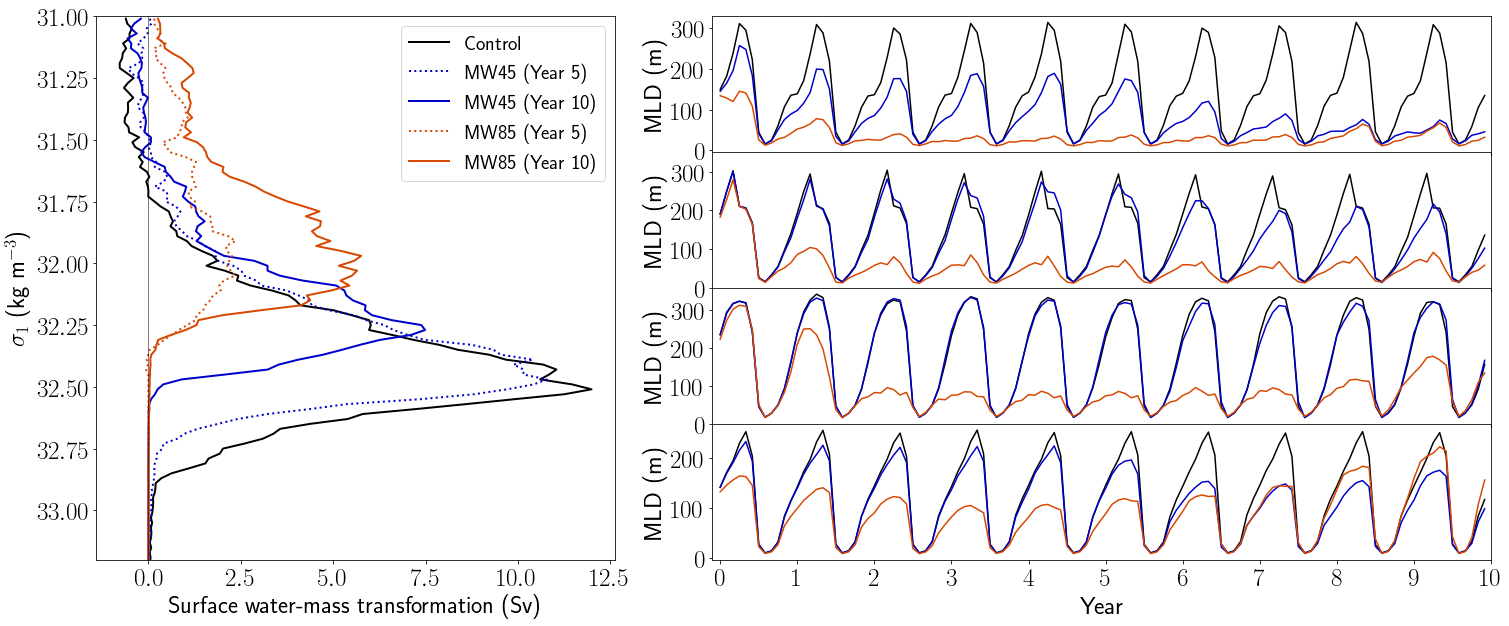

In [28]:
fig = plt.figure(figsize = (25,10))
gs = gridspec.GridSpec(4,2, width_ratios = [2,3])
ax= plt.subplot(gs[0:4,0])
gs.update(hspace = 0,wspace = 0.15)

shelf_SWMT_plot(ax)

ax0, ax1, ax2, ax3 = plt.subplot(gs[0,1]),plt.subplot(gs[1,1]) ,plt.subplot(gs[2,1]), plt.subplot(gs[3,1])

ax0.plot(np.arange(0,10,1/12), ross_mld_control_mean.values, 'k')
ax1.plot(np.arange(0,10,1/12), adelie_mld_control_mean.values, 'k')
ax2.plot(np.arange(0,10,1/12), prydz_mld_control_mean.values, 'k')
ax3.plot(np.arange(0,10,1/12), weddell_mld_control_mean.values, 'k')

ax0.plot(np.arange(0,10,1/12), ross_mld_rcp45_mean.values[0:120], 'mediumblue') ## accidentally loaded extra timestep
ax1.plot(np.arange(0,10,1/12), adelie_mld_rcp45_mean.values[0:120], 'mediumblue')
ax2.plot(np.arange(0,10,1/12), prydz_mld_rcp45_mean.values[0:120], 'mediumblue')
ax3.plot(np.arange(0,10,1/12), weddell_mld_rcp45_mean.values[0:120], 'mediumblue')

ax0.plot(np.arange(0,10,1/12), ross_mld_rcp85_mean.values, color = orange_color)
ax1.plot(np.arange(0,10,1/12), adelie_mld_rcp85_mean.values, color = orange_color)
ax2.plot(np.arange(0,10,1/12), prydz_mld_rcp85_mean.values, color = orange_color)
ax3.plot(np.arange(0,10,1/12), weddell_mld_rcp85_mean.values, color = orange_color)

ax0.set_xlim([-0.1,10])
ax1.set_xlim([-0.1,10])
ax2.set_xlim([-0.1,10])
ax3.set_xlim([-0.1,10])
ax1.set_ylim([0,350])
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
ax3.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax0.set_yticks([0,100,200,300])
ax1.set_yticks([0,100,200,300])
ax2.set_yticks([0,100,200,300])
ax3.set_yticks([0,100,200])
ax3.set_xlabel('Year')
ax0.set_ylabel('MLD (m)')
ax1.set_ylabel('MLD (m)')
ax2.set_ylabel('MLD (m)')
ax3.set_ylabel('MLD (m)')

figurepath = 'Fig6.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()   

I also made a map outlining the masked regions but I won't repeat that here, it's very straightforward.